In [1]:
import torch
import dataLoader
from model import CNN_LSTM
import numpy as np
from keras.utils.np_utils import to_categorical
import plot_cm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib

Using TensorFlow backend.


In [2]:
dl = 0  ## 时延
ts = 12 ## 滑窗宽度
lb = 1  ## 步长
modelPath = "./checkpoints/res8_12_0.10/CNN-LSTM-99.t7"  ## 模型所在地址
testRoot = "./data/test"
rRoot = "./data/r/r_0.10.txt"
saveRoot = "./results/res8_12_0.10"

In [3]:
##### 加载测试数据
X_test, y_test, mask_test = dataLoader.window_process(testRoot, rRoot, dl, 160, ts, lb)
X_test = np.array(X_test)
y_test = np.array(y_test)
mask_test = np.array(mask_test)
y_test = to_categorical(y_test, 22)

# 对数据进行随机打乱
permutation = np.random.permutation(X_test.shape[0])
X_test = X_test[permutation, :, :, :]
y_test = y_test[permutation, :]
mask_test = mask_test[permutation, :, :]

inputs = torch.Tensor(X_test)
target = torch.Tensor(y_test)
mask = torch.Tensor(mask_test)  

In [4]:
##### 加载模型
net = CNN_LSTM.CNN_LSTM(ts)
checkpoint = torch.load(modelPath)
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [5]:
##### 运行模型
net.eval()
with torch.no_grad():
    x2_atten, atten2, x3_atten, atten3, x1, x2, x3, x4, x = net(inputs, mask)

In [6]:
##### 计算测试准确率
total = x.size(0)
_, predicted = torch.max(x.data, 1)
_, trueValue = torch.max(target.data, 1)
correct = predicted.eq(trueValue.data).sum()
acc = int(correct.data) / total
np.savetxt(saveRoot + "acc.txt", [acc])

In [7]:
##### 获得混淆矩阵
cm = confusion_matrix(trueValue.numpy(), predicted.numpy())

In [8]:
##### 定义图片上的标签
attack_types = ['Normal', 'Fault 1', 'Fault 2', 'Fault 3', 'Fault 4', 
                'Fault 5', 'Fault 6', 'Fault 7', 'Fault 8', 'Fault 9', 'Fault 10', 'Fault 11', 'Fault 12','Fault 13', 
                'Fault 14', 'Fault 15', 'Fault 16', 'Fault 17', 'Fault 18', 'Fault 19', 'Fault 20', 'Fault 21']

In [9]:
##### 定义图片上的字体
font = {'family': 'Times New Roman',
         'style': 'normal',
         'weight': 'bold',
        #'color':  'darkred', 
        'size': 20,
        }

Normalized confusion matrix


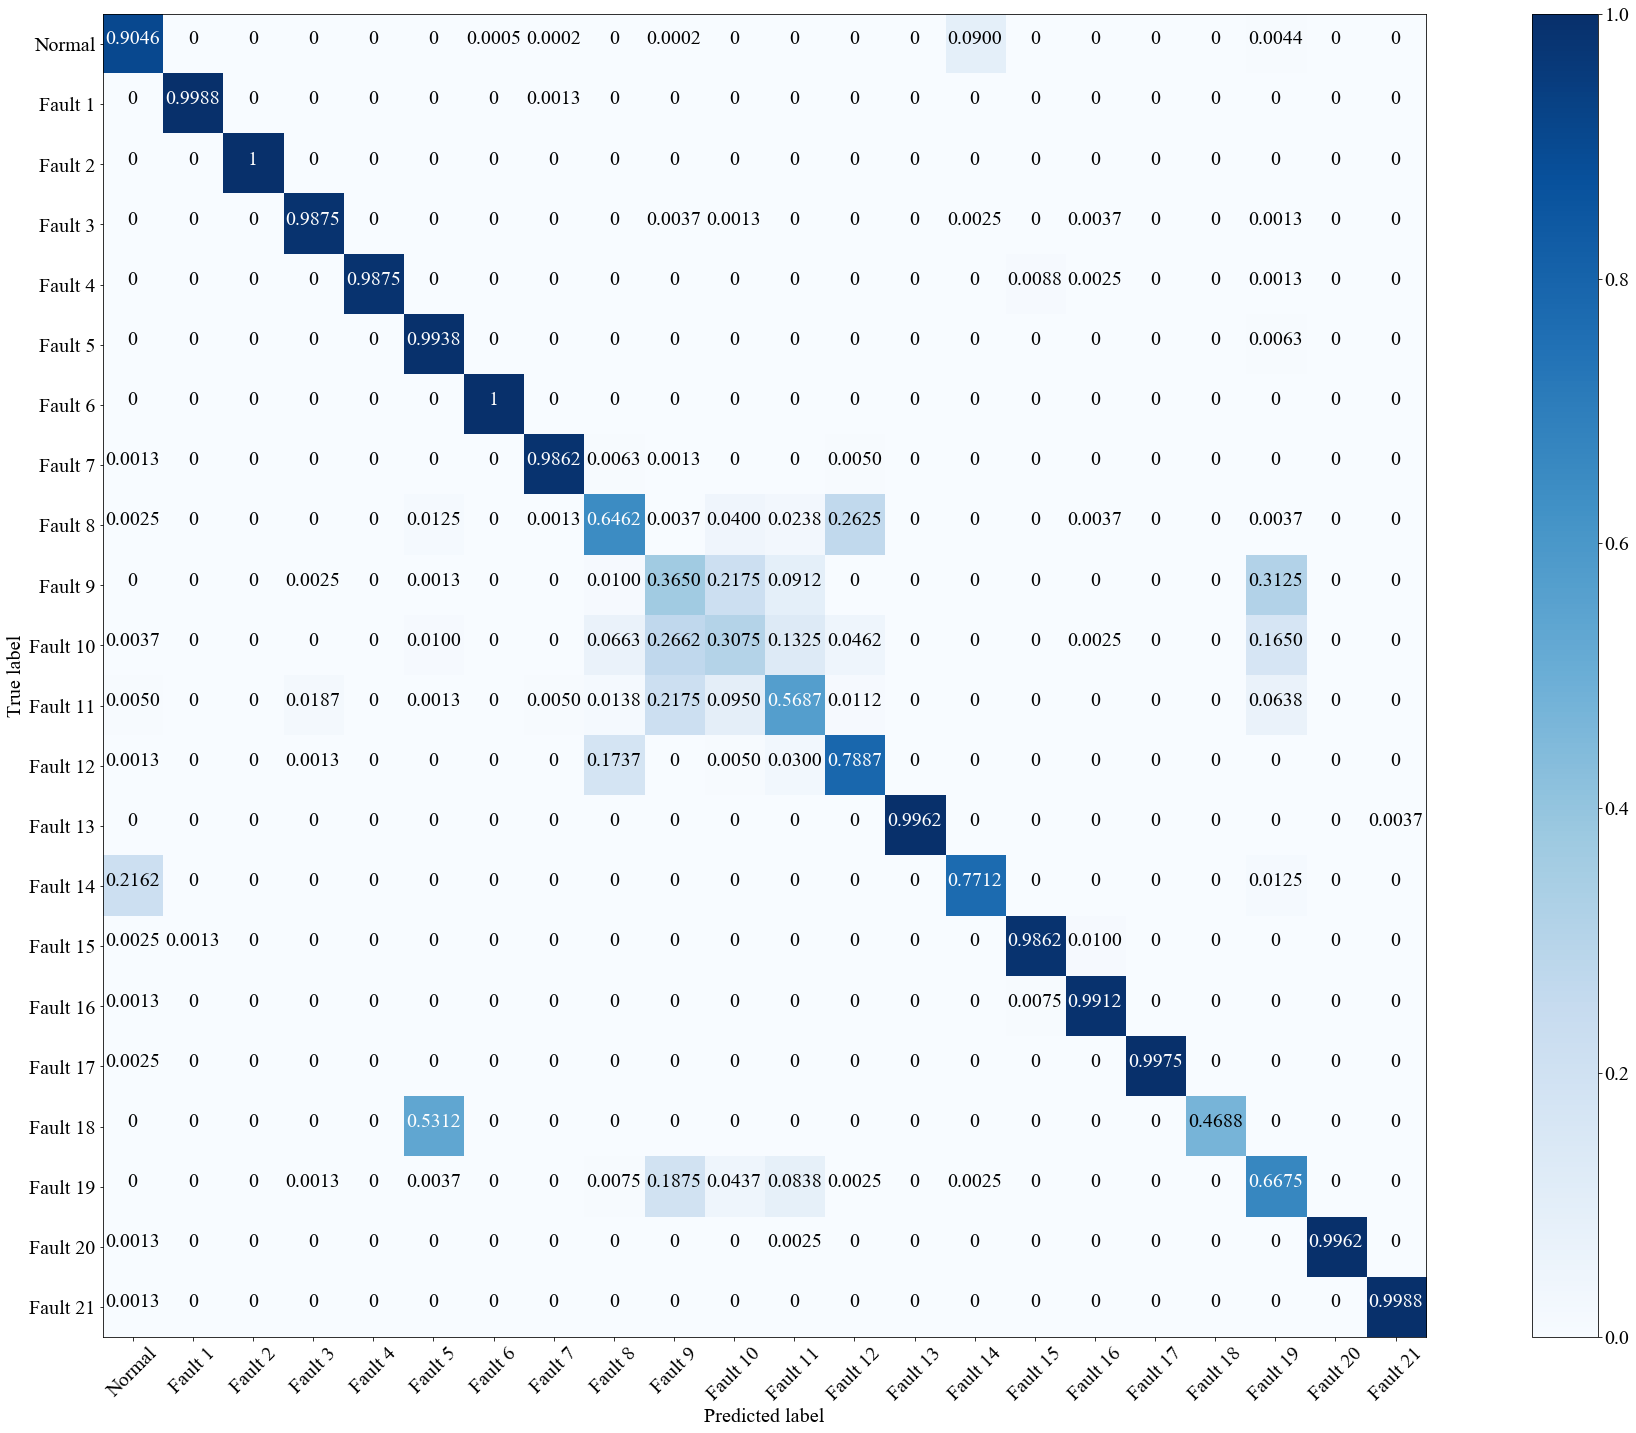

In [10]:
matplotlib.rc('font', **font)
plt.figure(figsize=(30, 20))
plot_cm.plot_confusion_matrix(cm, classes=attack_types, saveRoot=saveRoot + "cm.svg", normalize=True)

In [11]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [12]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
np.savetxt(saveRoot + "FDR.txt", TPR)
np.savetxt(saveRoot + "FPR.txt", FPR)